In [1]:
import requests
from PIL import Image
import io
# import tensorflow as tf
import torch
import datetime
from pathlib import Path
from datasets import DatasetDict
from datasets import Dataset
import time
from tqdm import tqdm

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
from datasets import load_dataset

dataset = load_dataset("stochastic/random_streetview_images_pano_v0.0.2", split="train")

In [14]:
# preprocessing - this took 6min 48 seconds on my computer... jk 12 min second time
from torchvision.transforms import v2
import torchvision.transforms as transforms

# data preprocessing
image_transforms = v2.Compose([
    v2.CenterCrop((561, 1010)),  # crops the middle image from the panorama
    v2.Resize((224, 224)),  # resizing the image to 224x224 for easier processing
    transforms.ToTensor()  # converting the image to a tensor
])

def transform(batch):
    # Transform each image in the batch and ensure it has 3 channels
    batch["image"] = [image_transforms(image.convert("RGB")) for image in batch["image"]]
    del batch["latitude"]
    del batch["longitude"]
    del batch["address"]
    return batch

# Apply the transformations to the dataset
dataset = dataset.map(transform, batched=True, batch_size=8)


Map:   0%|          | 0/11054 [00:00<?, ? examples/s]

Map: 100%|██████████| 11054/11054 [09:00<00:00, 20.44 examples/s]


In [27]:
print(len(dataset[0]['image']))
print(len(dataset[0]['image'][0]))
print(len(dataset[0]['image'][0][0]))


3
224
224


In [31]:
# Make split and save
train_testvalid = dataset.train_test_split(test_size=0.4)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

datasets = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})
datasets.save_to_disk("./data")

Saving the dataset (7/9 shards):  78%|███████▊  | 5159/6632 [00:50<00:14, 102.92 examples/s]


OSError: [Errno 28] No space left on device

In [4]:
country_codes = ["ZA","KR","AR","BW","GR","SK","HK","NL","PE","AU","KH","LT","NZ","RO","MY","SG","AE","FR","ES","IT","IE","LV","IL","JP","CH","AD","CA","RU","NO","SE","PL","TW","CO","BD","HU","CL","IS","BG","GB","US","SI","BT","FI","BE","EE","SZ","UA","CZ","BR","DK","ID","MX","DE","HR","PT","TH"]
country_dict = {}
# TODO: these might need to be tensor arrays but thats easy enough to change if needed
for i in range(len(country_codes)):
    country_dict[country_codes[i]] = [0]*len(country_codes)
    country_dict[country_codes[i]][i] = 1
# print(country_dict)


In [6]:
# referenced: https://blog.paperspace.com/convolutional-autoencoder/
# autoencoder classes (CREDIT: LARGELY TAKEN FROM 6_AUTOENCODER NOTEBOOK, but encoder and decoder architectures modified to be convolutional)
# should only have Encoder that has a latent dimension of 50 - corresponding to country weights

class MLPEncoder(torch.nn.Module):

    def __init__(self,
                 number_of_hidden_layers: int,
                 latent_size: int,
                 hidden_size: int,
                 input_size: int,
                 activation: torch.nn.Module):

        super().__init__()

        self.latent_size = latent_size
        assert number_of_hidden_layers >= 0, "Decoder number_of_hidden_layers must be at least 0"

        layers = []
        in_channels = 3
        out_channels = 16
        layers.append(torch.nn.Conv2d(in_channels, #in_channels
                                      out_channels, #out_channels
                                      3, #kernel_size
                                      stride=2, #stride 
                                      padding=1
                                      ))
        layers.append(activation)
        # 32 x 32
        layers.append(torch.nn.Conv2d(out_channels, #in_channels
                                      out_channels, #out_channels
                                      3, #kernel_size
                                      stride=1, #stride 
                                      padding=1
                                      ))
        layers.append(activation)
        layers.append(torch.nn.Conv2d(out_channels, #in_channels
                                      out_channels * 2, #out_channels
                                      3, #kernel_size
                                      stride=2,  #stride
                                      padding=1 
                                      ))
        layers.append(activation)
        #16 x 16
        layers.append(torch.nn.Conv2d(out_channels * 2, #in_channels
                                      out_channels * 2, #out_channels
                                      3, #kernel_size
                                      stride=1,  #stride 
                                      padding=1
                                      ))
        layers.append(activation)
        # 8x8 feature maps
        # 64 out channels
        layers.append(torch.nn.Conv2d(out_channels * 2, #in_channels
                                      out_channels*4, #out_channels
                                      3, #kernel_size
                                      stride=2,  #stride 
                                      padding=1
                                      ))
        layers.append(activation)
        # input is now 8x8 feature maps for out_channels*4 channels.
        layers.append(torch.nn.Flatten())
        #flatten to latent_size 
        layers.append(torch.nn.Linear(4*out_channels*8*8 , # features in
                                      latent_size # features out
                                      ))
        layers.append(activation)
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        #return torch.rand(1,self.latent_size)
        return self.net(x)


Loss = torch.nn.BCELoss()

In [7]:
# define our training parameters and model
hidden_layers = 4
hidden_size = 30

latent_size = 55
## this might need to change
input_size = 64
lr = 0.001
# lambda weight for classifier's loss
lamb = 1

# fix random seed
torch.manual_seed(0)

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPEncoder( number_of_hidden_layers=hidden_layers,
                 latent_size=latent_size,
                 hidden_size=hidden_size,
                 input_size=input_size,
                 activation=torch.nn.ReLU()).to(device)

# use an optimizer to handle parameter updates
opt = torch.optim.Adam(model.parameters(), lr=lr)

# save all log data to a local directory
run_dir = "logs"

# to clear out TensorBoard and start totally fresh, we'll need to
# remove old logs by deleting them from the directory
!rm -rf ./logs/

# timestamp the logs for each run so we can sort through them
run_time = datetime.datetime.now().strftime("%I%M%p on %B %d, %Y")

# initialize a SummaryWriter object to handle all logging actions
from torch.utils.tensorboard import SummaryWriter
logger = SummaryWriter(log_dir=Path(run_dir) / run_time, flush_secs=20)

2024-03-13 16:04:46.859681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# load data from disk
data = datasets.load_from_disk("./data")
data = data.with_format("torch")

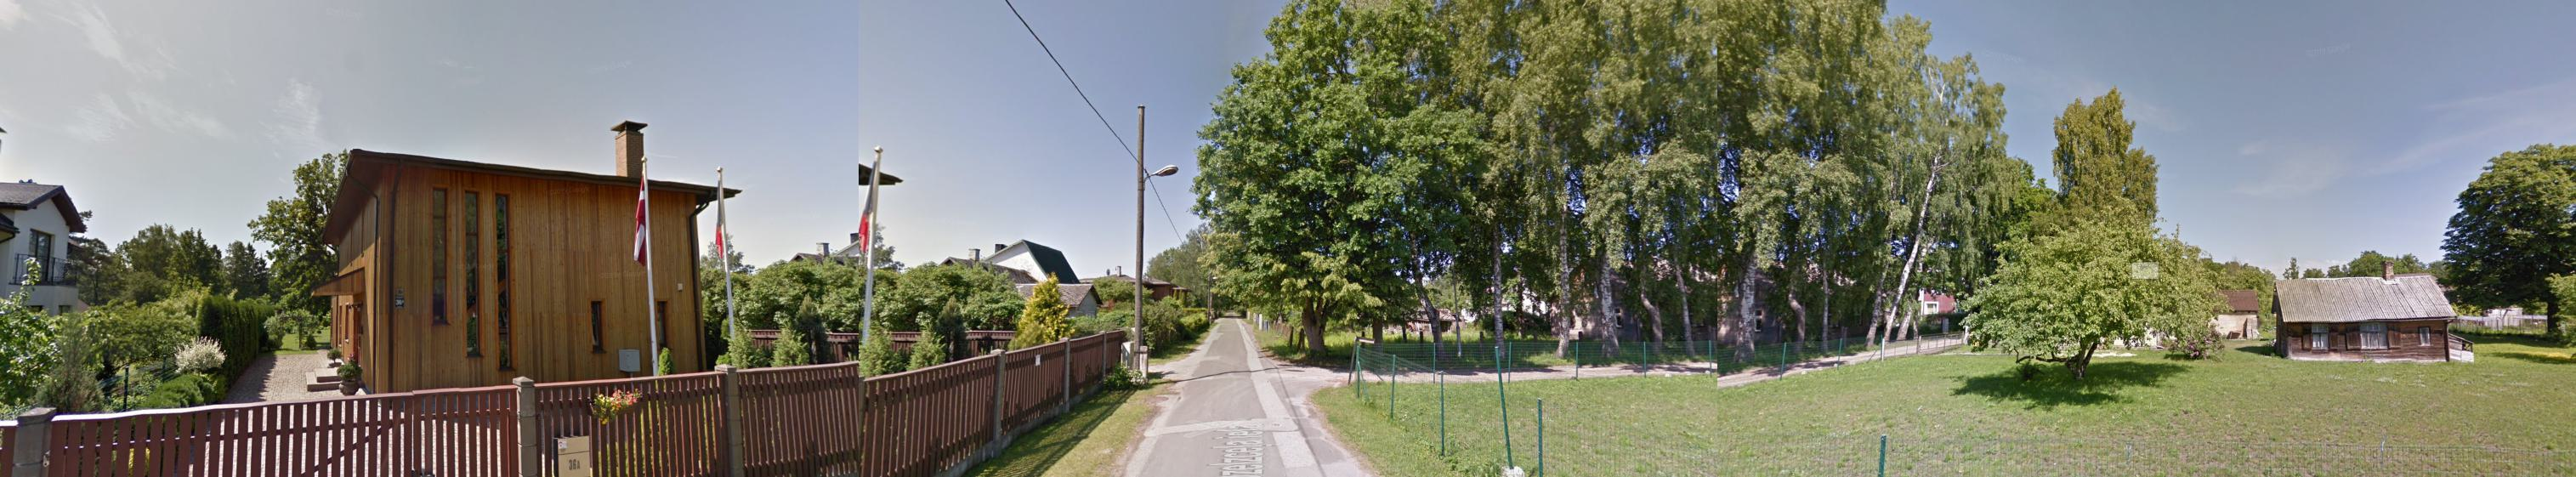

In [10]:
# test the datatype of the dataset - the datasets['train']['image'] should be a tensor
type(datasets['train'][0]['image'])
datasets['train'][0]['image']

In [20]:
# (***credit***: mostly taken from provided notebook )
# training

epochs = 100
start_time = time.time()
loss_history = []
valid_history = []
acc_history = []
valid_acc_history = []
report_every = 5


for epoch in range(epochs):

    # weight batch losses/scores proportional to batch size
    iter_count = 0
    valid_iter_count = 0
    loss_epoch = 0
    class_accuracy_epoch = 0
    valid_loss_epoch = 0
    valid_accuracy_epoch = 0
    ###
    ### IMAGE_DATA_TRAIN is training data, shape is 610 x 3 x 64 x 64
    ### 
    
   # print(batched_image_data_train[0][0].shape)

    # test with literally only one image
    #batched_image_data_train = [batched_image_data_train[0][0].unsqueeze(0)]
    for idx, img in enumerate(datasets['train']):
        
        x = img['image'][0]
        x = torch.tensor(x)
        print(x)
        # flatten input images and move to device\
        # *****
        x = x / 255
        # plot x_real later to see if this is correct
        x = x.to(device)
        model.zero_grad()

        # train on a batch of inputs
        pred_labels = model(x)

        # get the true label
        label = country_dict[img['country_code']]
        loss = Loss(label, pred_labels)
        loss.backward()
        opt.step()

        # log loss
        loss_epoch += loss.detach().item()    

        # classification accuracy
        # add 1 to class_accuracy_epoch if the classification is correct, else 0
        # find index of max probability from pred_labels
        c = torch.argmax(pred_labels)
        # find index of 1 from label
        true_class = torch.argmax(label)

        acc = (true_class == c)
        class_accuracy_epoch += acc
        iter_count += 1
        # print(f"true: {true_class}")
        # print(f"pred: {classification.mean()}")
        # print(f"acc: {acc}")

    # plot loss
    loss_epoch 
    class_accuracy_epoch /= iter_count #accuracy as a percent
   # print(iter_count)
    logger.add_scalar("mse_loss", loss_epoch, epoch)
    loss_history.append(loss_epoch)
    acc_history.append(class_accuracy_epoch) 
 
            
            # logger.add_scalar("mse_loss_valid", valid_loss_epoch, epoch)
    # # plot example generated images
    # with torch.no_grad():
    #     reconstructed_batch = model(example_batch.reshape(batch_size, -1)).reshape(batch_size, 1, image_size, image_size)
    #     logger.add_image("reconstructed_images", make_grid(reconstructed_batch, math.floor(math.sqrt(batch_size)), title="Reconstructed Images"), epoch)
        # calculate validation loss

    with torch.no_grad():
        for valid_idx, valid_data in enumerate(datasets['valid']):
            x_valid = valid_data['image']#.float()
            x_valid = x_valid / 255
            x_valid = x_valid.to(device)
            pred_labels = model(x_valid)

            label_valid = country_dict[valid_data['country_code']]
            valid_loss = Loss(label_valid, pred_labels)
            valid_loss_epoch += valid_loss.detach().item()

            
            # classification accuracy
            # add 1 to class_accuracy_epoch if the classification is correct, else 0
            c = torch.argmax(pred_labels) # find index of max probability from pred_labels
            true_class = torch.argmax(label) # find index of 1 from label
            
            valid_acc = (true_class == c) 
            valid_accuracy_epoch += valid_acc
            valid_iter_count += 1
            # print(f"true: {true_class}")
            # print(f"pred: {classification.mean()}")
            # print(f"acc: {valid_acc}")
        valid_loss_epoch 
        valid_history.append(valid_loss_epoch)
        valid_accuracy_epoch /= valid_iter_count
        valid_acc_history.append(valid_accuracy_epoch)

    if (epoch + 1) % report_every == 0:
        mins = (time.time() - start_time) / 60
        print(f"Epoch: {epoch + 1:5d}\tMSE Loss: {loss_epoch :6.4f}\t in {mins:5.1f}min")
        print()

tensor([[0.5098, 0.5098, 0.5098,  ..., 0.5412, 0.5294, 0.4784],
        [0.5098, 0.5098, 0.5098,  ..., 0.5529, 0.5529, 0.4902],
        [0.5098, 0.5098, 0.5098,  ..., 0.5569, 0.5451, 0.4784],
        ...,
        [0.7294, 0.6980, 0.6627,  ..., 0.2980, 0.3098, 0.3294],
        [0.6902, 0.6667, 0.6667,  ..., 0.3608, 0.3373, 0.3294],
        [0.6510, 0.6745, 0.6902,  ..., 0.3725, 0.3373, 0.2941]])


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [224, 224]